In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from dataset import *
from spdnet.spd import SPDTransform, SPDTangentSpace, SPDRectified
from spdnet.optimizer import StiefelMetaOptimizer

use_cuda = False

In [2]:
%cd ..

/Users/JJ/Desktop/fMRISPDCluster


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.trans1 = SPDTransform(57, 20)
        self.trans2 = SPDTransform(20, 10)
        self.trans3 = SPDTransform(10, 2)
        self.rect1  = SPDRectified()
        self.rect2  = SPDRectified()
        self.rect3  = SPDRectified()
        self.tangent = SPDTangentSpace(2)
        self.linear = nn.Linear(3, 17, bias=True)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.trans1(x)
        x = self.rect1(x)
        x = self.trans2(x)
        x = self.rect2(x)
        x = self.trans3(x)
        x = self.rect3(x)
        x = self.tangent(x)
        # x = self.dropout(x)
        x = self.linear(x)
        return x

In [4]:
def sliding_window(x, ws=30):
    d, n = x.shape
    return np.stack([(1/n)*np.matmul(x[:, i:ws+i], x[:, i:ws+i].T) for i in range(n-ws)])

In [5]:
def get_sliding_labels(x, ws=30):
    n = x.shape[0]
    return np.stack([x[int(ws/2)+i] for i in range(n-ws)])

In [6]:
class SPDataset(Dataset):
    def __init__(self, shuffle=False, scan_id=1, ws=30):
        super(SPDataset, self).__init__()
        self.scan_id = scan_id
        self.ws = ws
        lbls = np.loadtxt('./fMRIdata/timingLabels_WM_scan1.csv', dtype=np.int32)
        data = []
        labels = []
        for i in range(1,31):
            tmp_data = pd.read_csv(f'./fMRIdata/subject_1{i:02d}_scan{scan_id}.csv')
            tmp_data = sliding_window(tmp_data.values, ws)
            tmp_lbls = get_sliding_labels(lbls, ws)
            data.append(tmp_data)
            labels.append(tmp_lbls)
        self.data = np.concatenate(data, axis=0)
        self.labels = np.concatenate(labels, axis=0)[..., None] - 1.

        if shuffle:
            random.shuffle(self.data)

        self.nSamples = len(self.data) 
        print(self.nSamples)
        self.nClasses = 17
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, idx):
        return {'data': torch.from_numpy(self.data[idx].astype(np.float32)), 
                'label': torch.from_numpy(self.labels[idx].astype(np.compat.long))}

In [7]:
transformed_dataset = SPDataset(scan_id=1)
dataloader = DataLoader(transformed_dataset, batch_size=7, shuffle=True, num_workers=4)

transformed_dataset_val = SPDataset(scan_id=2)
dataloader_val = DataLoader(transformed_dataset_val, batch_size=7, shuffle=False, num_workers=4)

model = Net()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = StiefelMetaOptimizer(optimizer)

10890
10890


In [8]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0.0
    total = 0.0
    bar = tqdm(enumerate(dataloader))
    for batch_idx, sample_batched in bar:
        inputs = sample_batched['data']
        targets = sample_batched['label'].squeeze()

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1.0), 100.*correct/total, correct, total))

    return (train_loss/(batch_idx+1), 100.*correct/total)

In [9]:
best_acc = 0
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0.0
    total = 0.0
    bar = tqdm(enumerate(dataloader_val))
    for batch_idx, sample_batched in bar:
        inputs = sample_batched['data']
        targets = sample_batched['label'].squeeze()

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/spd_ckpt.t7')
        best_acc = acc

    return (test_loss/(batch_idx+1), 100.*correct/total)

In [10]:
log_file = open('log_spd.txt', 'a')

start_epoch = 41
for epoch in range(start_epoch, start_epoch+30):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    log_file.write('%d,%f,%f,%f,%f\n' % (epoch, train_loss, train_acc, test_loss, test_acc))
    log_file.flush()

log_file.close()


Epoch: 11


Loss: 2.406 | Acc: 21.047% (2292/10890): : 1556it [00:32, 47.24it/s]
Loss: 2.419 | Acc: 18.448% (2009/10890): : 1556it [00:12, 121.35it/s]


Saving..

Epoch: 12


Loss: 2.197 | Acc: 26.015% (2833/10890): : 1556it [00:29, 52.06it/s]
Loss: 2.460 | Acc: 19.192% (2090/10890): : 1556it [00:12, 121.50it/s]


Saving..

Epoch: 13


Loss: 2.117 | Acc: 29.339% (3195/10890): : 1556it [00:23, 65.44it/s]
Loss: 2.560 | Acc: 17.264% (1880/10890): : 1556it [00:10, 142.97it/s]


Epoch: 14



Loss: 2.085 | Acc: 29.780% (3243/10890): : 1556it [00:23, 65.02it/s]
Loss: 2.582 | Acc: 16.134% (1757/10890): : 1556it [00:10, 147.61it/s]



Epoch: 15


Loss: 2.069 | Acc: 29.917% (3258/10890): : 1556it [00:23, 65.08it/s]
Loss: 2.613 | Acc: 16.382% (1784/10890): : 1556it [00:10, 151.53it/s]



Epoch: 16


Loss: 2.058 | Acc: 29.752% (3240/10890): : 1556it [00:23, 65.25it/s]
Loss: 2.623 | Acc: 17.181% (1871/10890): : 1556it [00:10, 153.68it/s]


Epoch: 17



Loss: 2.055 | Acc: 30.156% (3284/10890): : 1556it [00:28, 55.56it/s]
Loss: 2.685 | Acc: 16.281% (1773/10890): : 1556it [00:11, 139.37it/s]



Epoch: 18


Loss: 2.049 | Acc: 30.294% (3299/10890): : 1556it [00:22, 68.50it/s]
Loss: 2.646 | Acc: 17.695% (1927/10890): : 1556it [00:09, 159.54it/s]



Epoch: 19


Loss: 2.042 | Acc: 30.762% (3350/10890): : 1556it [00:22, 68.52it/s]
Loss: 2.724 | Acc: 15.730% (1713/10890): : 1556it [00:09, 159.54it/s]



Epoch: 20


Loss: 2.042 | Acc: 30.147% (3283/10890): : 1556it [00:22, 68.65it/s]
Loss: 2.709 | Acc: 16.189% (1763/10890): : 1556it [00:09, 160.88it/s]


Epoch: 21



Loss: 2.039 | Acc: 30.771% (3351/10890): : 1556it [00:22, 68.89it/s]
Loss: 2.724 | Acc: 16.400% (1786/10890): : 1556it [00:09, 158.60it/s]


Epoch: 22



Loss: 2.034 | Acc: 30.239% (3293/10890): : 1556it [00:22, 68.69it/s]
Loss: 2.707 | Acc: 16.189% (1763/10890): : 1556it [00:10, 154.81it/s]



Epoch: 23


Loss: 2.031 | Acc: 30.413% (3312/10890): : 1556it [00:22, 68.67it/s]
Loss: 2.702 | Acc: 16.850% (1835/10890): : 1556it [00:11, 139.77it/s]


Epoch: 24



Loss: 2.026 | Acc: 30.560% (3328/10890): : 1556it [00:25, 61.31it/s]
Loss: 2.726 | Acc: 15.923% (1734/10890): : 1556it [00:10, 152.70it/s]



Epoch: 25


Loss: 2.024 | Acc: 30.092% (3277/10890): : 1556it [00:24, 64.04it/s]
Loss: 2.800 | Acc: 15.317% (1668/10890): : 1556it [00:09, 159.56it/s]



Epoch: 26


Loss: 2.022 | Acc: 30.909% (3366/10890): : 1556it [00:25, 60.24it/s]
Loss: 2.788 | Acc: 13.535% (1474/10890): : 1556it [00:09, 165.34it/s]



Epoch: 27


Loss: 2.018 | Acc: 30.588% (3331/10890): : 1556it [00:22, 68.38it/s]
Loss: 2.749 | Acc: 15.996% (1742/10890): : 1556it [00:11, 134.28it/s]


Epoch: 28



Loss: 2.018 | Acc: 30.652% (3338/10890): : 1556it [00:31, 49.43it/s]
Loss: 2.754 | Acc: 14.784% (1610/10890): : 1556it [00:11, 132.75it/s]



Epoch: 29


Loss: 2.014 | Acc: 30.808% (3355/10890): : 1556it [00:35, 44.12it/s]
Loss: 2.790 | Acc: 15.482% (1686/10890): : 1556it [00:12, 126.18it/s]



Epoch: 30


Loss: 2.015 | Acc: 30.634% (3336/10890): : 1556it [00:26, 59.33it/s]
Loss: 2.788 | Acc: 13.783% (1501/10890): : 1556it [00:13, 116.85it/s]



Epoch: 31


Loss: 2.017 | Acc: 30.771% (3351/10890): : 1556it [00:24, 63.49it/s]
Loss: 2.787 | Acc: 15.712% (1711/10890): : 1556it [00:10, 141.72it/s]


Epoch: 32



Loss: 2.008 | Acc: 31.359% (3415/10890): : 1556it [00:25, 60.80it/s]
Loss: 2.778 | Acc: 15.702% (1710/10890): : 1556it [00:10, 151.43it/s]



Epoch: 33


Loss: 2.010 | Acc: 30.698% (3343/10890): : 1556it [00:24, 64.07it/s]
Loss: 2.779 | Acc: 16.492% (1796/10890): : 1556it [00:10, 151.13it/s]



Epoch: 34


Loss: 2.005 | Acc: 31.028% (3379/10890): : 1556it [00:24, 62.50it/s]
Loss: 2.828 | Acc: 14.252% (1552/10890): : 1556it [00:10, 154.97it/s]



Epoch: 35


Loss: 2.008 | Acc: 31.084% (3385/10890): : 1556it [00:23, 64.89it/s]
Loss: 2.824 | Acc: 16.483% (1795/10890): : 1556it [00:10, 154.21it/s]



Epoch: 36


Loss: 2.004 | Acc: 31.423% (3422/10890): : 1556it [00:24, 64.64it/s]
Loss: 2.823 | Acc: 14.389% (1567/10890): : 1556it [00:09, 155.76it/s]



Epoch: 37


Loss: 2.005 | Acc: 31.837% (3467/10890): : 1556it [00:24, 62.85it/s]
Loss: 2.818 | Acc: 14.665% (1597/10890): : 1556it [00:09, 160.52it/s]


Epoch: 38



Loss: 1.999 | Acc: 31.772% (3460/10890): : 1556it [00:23, 66.78it/s]
Loss: 2.818 | Acc: 15.601% (1699/10890): : 1556it [00:09, 159.79it/s]



Epoch: 39


Loss: 1.999 | Acc: 31.093% (3386/10890): : 1556it [00:23, 67.56it/s]
Loss: 2.849 | Acc: 13.471% (1467/10890): : 1556it [00:09, 162.43it/s]



Epoch: 40


Loss: 1.998 | Acc: 31.341% (3413/10890): : 1556it [00:23, 66.74it/s]
Loss: 2.835 | Acc: 14.628% (1593/10890): : 1556it [00:09, 160.64it/s]


In [128]:
activation = {}
z=[]
o=[]
c=[]
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.tangent.register_forward_hook(get_activation('o'))
model.rect3.register_forward_hook(get_activation('r3'))
for batch_idx, sample_batched in enumerate(dataloader_val):
    inputs = sample_batched['data']
    targets = sample_batched['label'].squeeze()

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)
    o += [activation['o']]
    z += [activation['r3']]
    c += [targets]

In [129]:
o = torch.cat(o)
z = torch.cat(z)
c = torch.cat(c)

In [156]:
zx = []
for A in z:
    indices = np.triu_indices_from(A)
    A = np.asarray(A[indices])
    zx.append(A)
z = np.stack(zx)

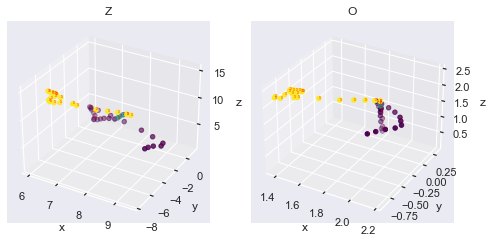

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure(figsize=plt.figaspect(0.5))

def embedding_viz(xyz, c, idx, tittle='z', N=50, perm=False):
    ax = fig.add_subplot(1, 2, idx, projection='3d')
    ax.title.set_text(tittle)
    idx = np.arange(len(c))
    if perm:
        idx = np.random.permutation(idx)
    p = idx[:N]
    
    xs = xyz[p, 0]
    ys = xyz[p, 1]
    zs = xyz[p, 2]
    color = c[p]

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.scatter(xs, ys, zs, c=color, cmap='viridis')

    for i, p in enumerate(zip(xs, ys, zs)):
        ax.text(p[0], p[1], p[2], str(int(c[i])), color="red", fontsize=3)

embedding_viz(z, c, 1, 'Z')
embedding_viz(o, c, 2, 'O')
plt.show()

In [159]:
np.sum(o.numpy()-z)

-391917.6